This project uses deep neural network(DNN)to predict hand-written digit graphs.
![](https://ai-studio-static-online.cdn.bcebos.com/ba26eac845334208851e72c7a2dfef5e1eec566894ba430aba7492e72c49cacd)

 The flow chart shown as follows:

![](https://raw.githubusercontent.com/ffflora/mnist-project/master/flow-chart.PNG)

Packages:

numpy  
PIL------------> Python Image Library  
matplotlib  
os  
paddle --------> Neural network model

In [2]:

import numpy as np
import paddle as paddle
import paddle.fluid as fluid
from PIL import Image
import matplotlib.pyplot as plt
import os

# **Step1：Data Preperation**

(1)Dataset:  

MNIST contains 60000 in training set and 10000 in test set. 
It has graphs and labels, graphs are in 28*28 pixels, labels are in 1-9.

![](https://ai-studio-static-online.cdn.bcebos.com/fc73217ae57f451a89badc801a903bb742e42eabd9434ecc8089efe19a66c076)

(2)train_reader and test_reader

paddle.dataset.mnist.train()and test()used to get the training set and test set.

paddle.reader.shuffle()used to buffer BUF_SIZE and shuffle it.

paddle.batch()each BATCH_SIZE makes a batch

（3）print and see how the data look like.  The data from PaddlePaddle's API has already been standarization and normalization.

[神经网络训练中，傻傻分不清Epoch、Batch Size和迭代](https://www.jiqizhixin.com/articles/2017-09-25-3)

In [1]:
!mkdir -p /home/aistudio/.cache/paddle/dataset/mnist/
!cp -r /home/aistudio/data/data65/*  /home/aistudio/.cache/paddle/dataset/mnist/
!ls /home/aistudio/.cache/paddle/dataset/mnist/

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [3]:
BUF_SIZE=512
BATCH_SIZE=128
# data provider, used to get data randomly from the buffer（缓存）. 

train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.mnist.train(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)

test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.mnist.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)
#用于打印，查看mnist数据
train_data=paddle.dataset.mnist.train();
sampledata=next(train_data())
print(sampledata)


(array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1. 

# **Step2.网络配置**
以下的代码判断就是定义一个简单的多层感知器，一共有三层，两个大小为100的隐层和一个大小为10的输出层，因为MNIST数据集是手写0到9的灰度图像，类别有10个，所以最后的输出大小是10。最后输出层的激活函数是Softmax，所以最后的输出层相当于一个分类器。加上一个输入层的话，多层感知器的结构是：输入层-->>隐层-->>隐层-->>输出层。

![](https://ai-studio-static-online.cdn.bcebos.com/cb69f928778c4299b75814179607a89eea770bdc409d4e08a87e2975cb96b19b)

In [4]:
# 定义多层感知器 
def multilayer_perceptron(input): 
    # 第一个全连接层，激活函数为ReLU 
    hidden1 = fluid.layers.fc(input=input, size=100, act='relu') 
    # 第二个全连接层，激活函数为ReLU 
    hidden2 = fluid.layers.fc(input=hidden1, size=100, act='relu') 
    # 以softmax为激活函数的全连接输出层，输出层的大小必须为数字的个数10 
    prediction = fluid.layers.fc(input=hidden2, size=10, act='softmax') 
    return prediction 

（2）定义数据层

输入的是图像数据。图像是 28 * 28 的灰度图，所以输入的形状是[1, 28, 28]，如果图像是32*32的彩色图，那么输入的形状是[3. 32, 32]，因为灰度图只有一个通道，而彩色图有RGB三个通道。

In [5]:
# 输入的原始图像数据，大小为1*28*28
image = fluid.layers.data(name='image', shape=[1, 28, 28], dtype='float32')#单通道，28*28像素值
# 标签，名称为label,对应输入图片的类别标签
label = fluid.layers.data(name='label', shape=[1], dtype='int64')          #图片标签

（3）获取分类器

In [6]:
# 获取分类器
predict = multilayer_perceptron(image)

（4）定义损失函数和准确率

这次使用的是交叉熵损失函数，该函数在分类任务上比较常用。

定义了一个损失函数之后，还有对它求平均值，训练程序必须返回平均损失作为第一个返回值，因为它会被后面反向传播算法所用到。。

同时我们还可以定义一个准确率函数，这个可以在我们训练的时候输出分类的准确率。

In [7]:
#使用交叉熵损失函数,描述真实样本标签和预测概率之间的差值
cost = fluid.layers.cross_entropy(input=predict, label=label)  
# 使用类交叉熵函数计算predict和label之间的损失函数
avg_cost = fluid.layers.mean(cost)
# 计算分类准确率
acc = fluid.layers.accuracy(input=predict, label=label)

（5）定义优化函数

这次我们使用的是Adam优化方法，同时指定学习率为0.001

In [8]:
# 获取测试程序
test_program = fluid.default_main_program().clone(for_test=True)
#使用Adam算法进行优化, learning_rate 是学习率(它的大小与网络的训练收敛速度有关系)
optimizer = fluid.optimizer.AdamOptimizer(learning_rate=0.001)  
opts = optimizer.minimize(avg_cost)

在上述模型配置完毕后，得到两个fluid.Program：fluid.default_startup_program() 与fluid.default_main_program() 配置完毕了。

参数初始化操作会被写入fluid.default_startup_program()

fluid.default_main_program()用于获取默认或全局main program(主程序)。该主程序用于训练和测试模型。fluid.layers 中的所有layer函数可以向 default_main_program 中添加算子和变量。default_main_program 是fluid的许多编程接口（API）的Program参数的缺省值。例如,当用户program没有传入的时候， Executor.run() 会默认执行 default_main_program 。

# **Step3.模型训练 and Step4.模型评估**
（1）创建训练的Executor

首先定义运算场所 fluid.CPUPlace()和 fluid.CUDAPlace(0)分别表示运算场所为CPU和GPU

Executor:接收传入的program，通过run()方法运行program。

In [9]:
# 定义使用CPU还是GPU，使用CPU时use_cuda = False,使用GPU时use_cuda = True
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

[]

（2）告知网络传入的数据分为两部分，第一部分是image值，第二部分是label值

DataFeeder负责将数据提供器（train_reader,test_reader）返回的数据转成一种特殊的数据结构，使其可以输入到Executor中。

In [10]:

feeder = fluid.DataFeeder(place=place, feed_list=[image, label])

(3)展示模型训练曲线

In [11]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

（4）训练并保存模型

训练需要有一个训练程序和一些必要参数，并构建了一个获取训练过程中测试误差的函数。必要参数有executor,program,reader,feeder,fetch_list。

**executor**表示之前创建的执行器

**program**表示执行器所执行的program，是之前创建的program，如果该项参数没有给定的话则默认使用defalut_main_program

**reader**表示读取到的数据

**feeder**表示前向输入的变量

**fetch_list**表示用户想得到的变量

Pass:0, Batch:0, Cost:2.70804, Accuracy:0.08594
Pass:0, Batch:200, Cost:0.34498, Accuracy:0.88281
Pass:0, Batch:400, Cost:0.19155, Accuracy:0.93750
Test:0, Cost:0.22953, Accuracy:0.92880
Pass:1, Batch:0, Cost:0.20893, Accuracy:0.92969
Pass:1, Batch:200, Cost:0.12913, Accuracy:0.96875
Pass:1, Batch:400, Cost:0.26919, Accuracy:0.90625
Test:1, Cost:0.14895, Accuracy:0.95392
save models to /home/aistudio/work/hand.inference.model
训练模型保存完成！


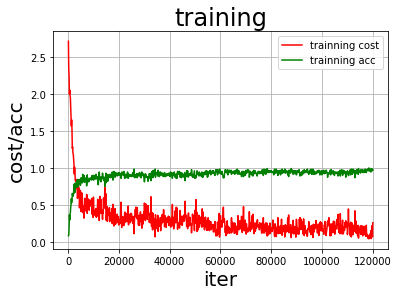

In [12]:
EPOCH_NUM=2
model_save_dir = "/home/aistudio/work/hand.inference.model"
for pass_id in range(EPOCH_NUM):
    # 进行训练
    for batch_id, data in enumerate(train_reader()):                         #遍历train_reader
        train_cost, train_acc = exe.run(program=fluid.default_main_program(),#运行主程序
                                        feed=feeder.feed(data),              #给模型喂入数据
                                        fetch_list=[avg_cost, acc])          #fetch 误差、准确率  
        
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])
        
        # 每200个batch打印一次信息  误差、准确率
        if batch_id % 200 == 0:
            print('Pass:%d, Batch:%d, Cost:%0.5f, Accuracy:%0.5f' %
                  (pass_id, batch_id, train_cost[0], train_acc[0]))

    # 进行测试
    test_accs = []
    test_costs = []
    #每训练一轮 进行一次测试
    for batch_id, data in enumerate(test_reader()):                         #遍历test_reader
        test_cost, test_acc = exe.run(program=test_program, #执行训练程序
                                      feed=feeder.feed(data),               #喂入数据
                                      fetch_list=[avg_cost, acc])           #fetch 误差、准确率
        test_accs.append(test_acc[0])                                       #每个batch的准确率
        test_costs.append(test_cost[0])                                     #每个batch的误差
        
       
    # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))                         #每轮的平均误差
    test_acc = (sum(test_accs) / len(test_accs))                            #每轮的平均准确率
    print('Test:%d, Cost:%0.5f, Accuracy:%0.5f' % (pass_id, test_cost, test_acc))
    
    #保存模型
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['image'],    #推理（inference）需要 feed 的数据
                                  [predict],    #保存推理（inference）结果的 Variables
                                  exe)             #executor 保存 inference model

print('训练模型保存完成！')
draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")

# **Step5.模型预测**

（1）图片预处理

在预测之前，要对图像进行预处理。

首先进行灰度化，然后压缩图像大小为28*28，接着将图像转换成一维向量，最后再对一维向量进行归一化处理。

In [13]:
def load_image(file):
    im = Image.open(file).convert('L')                        #将RGB转化为灰度图像，L代表灰度图像，像素值在0~255之间
    im = im.resize((28, 28), Image.ANTIALIAS)                 #resize image with high-quality 图像大小为28*28
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)#返回新形状的数组,把它变成一个 numpy 数组以匹配数据馈送格式。
    # print(im)
    im = im / 255.0 * 2.0 - 1.0                               #归一化到【-1~1】之间
    return im


（2）使用Matplotlib工具显示这张图像。

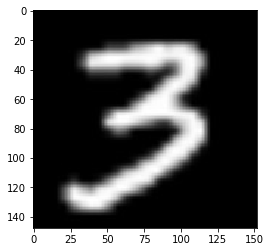

In [14]:
infer_path='/home/aistudio/data/data2304/infer_3.png'
img = Image.open(infer_path)
plt.imshow(img)   #根据数组绘制图像
plt.show()        #显示图像

(3)创建预测用的Executer

In [15]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()

(4)开始预测

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

In [16]:
# 加载数据并开始预测
with fluid.scope_guard(inference_scope):
    #获取训练好的模型
    #从指定目录中加载 推理model(inference model)
    [inference_program,                                            #推理Program
     feed_target_names,                                            #是一个str列表，它包含需要在推理 Program 中提供数据的变量的名称。 
     fetch_targets] = fluid.io.load_inference_model(model_save_dir,#fetch_targets：是一个 Variable 列表，从中我们可以得到推断结果。model_save_dir：模型保存的路径
                                                    infer_exe)     #infer_exe: 运行 inference model的 executor
    img = load_image(infer_path)

    results = infer_exe.run(program=inference_program,               #运行推测程序
                   feed={feed_target_names[0]: img},           #喂入要预测的img
                   fetch_list=fetch_targets)                   #得到推测结果,  
    # 获取概率最大的label
    lab = np.argsort(results)                                  #argsort函数返回的是result数组值从小到大的索引值
    #print(lab)
    print("该图片的预测结果的label为: %d" % lab[0][0][-1])     #-1代表读取数组中倒数第一列  

该图片的预测结果的label为: 3
